<a href="https://colab.research.google.com/github/JayceeLi66/NLP_Homework/blob/master/NLP_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install jsonlines

In [0]:
import os
import json
import jsonlines
import numpy as np
from collections import defaultdict

# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

## I. N-Gram Language Modeling

#### Utilities

In [0]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [0]:
datasets, vocab = load_wikitext()

--2019-09-30 18:36:20--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 107.152.24.197, 107.152.25.197
Connecting to nyu.box.com (nyu.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-09-30 18:36:20--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-09-30 18:36:20--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.24.199
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.24.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://publ

### Additive Smoothing

In [0]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [0]:
delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

Vocab size: 33175
Baseline (Additive smoothing, n=2, delta=0.0005)) Train Perplexity: 90.228
Baseline (Additive smoothing, n=2, delta=0.0005)) Valid Perplexity: 525.825
Baseline (Additive smoothing, n=3, delta=0.0005)) Train Perplexity: 26.768
Baseline (Additive smoothing, n=3, delta=0.0005)) Valid Perplexity: 2577.128
Baseline (Additive smoothing, n=4, delta=0.0005)) Train Perplexity: 19.947
Baseline (Additive smoothing, n=4, delta=0.0005)) Valid Perplexity: 9570.901


### I.1 Interpolation

In [0]:
class NGramInterpolation(object):
    def __init__(self, lambda_ls, vsize):
        self.l = lambda_ls
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for n in range(1, len(self.l)):
            for sequence in sequences:
                padded_sequence = ['<bos>']*(n-1) + sequence + ['<eos>']
                for i in range(len(padded_sequence) - n+1):
                    ngram = tuple(padded_sequence[i:i+n])
                    prefix, word = ngram[:-1], ngram[-1]
                    self.count[prefix][word] += 1
                    self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        n = len(self.l)
        padded_sequence = ['<bos>']*(n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - n):
            ngram = tuple(padded_sequence[i:i+n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp



    def ngram_prob(self, ngram):
        prob = self.l[0]/self.vsize
        for n in range(1, len(self.l)):
            prefix = ngram[-n:-1]
            word = ngram[-1]
            if self.total[prefix] != 0:
                prob += self.l[n] * self.count[prefix][word] / self.total[prefix]
        return prob

#### Tune $\lambda$ for n=2

In [0]:
lambda_range = [[0.33, 0.33, 0.34], [0.2, 0.3, 0.5], 
                [0.2, 0.8, 0], [0.2, 0, 0.8],
                [0.1, 0.1, 0.8]]
for l in lambda_range:
    lm = NGramInterpolation(lambda_ls=l, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])

    print("Interpolation smoothing, n=%d, lambda=%s, Train Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['train'])))
    print("Interpolation smoothing, n=%d, lambda=%s, Valid Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['valid'])))
    print()

Interpolation smoothing, n=2, lambda=[0.33, 0.33, 0.34], Train Perplexity: 167.716
Interpolation smoothing, n=2, lambda=[0.33, 0.33, 0.34], Valid Perplexity: 370.320

Interpolation smoothing, n=2, lambda=[0.2, 0.3, 0.5], Train Perplexity: 126.119
Interpolation smoothing, n=2, lambda=[0.2, 0.3, 0.5], Valid Perplexity: 316.744

Interpolation smoothing, n=2, lambda=[0.2, 0.8, 0], Train Perplexity: 1060.071
Interpolation smoothing, n=2, lambda=[0.2, 0.8, 0], Valid Perplexity: 907.352

Interpolation smoothing, n=2, lambda=[0.2, 0, 0.8], Train Perplexity: 92.656
Interpolation smoothing, n=2, lambda=[0.2, 0, 0.8], Valid Perplexity: 420.348

Interpolation smoothing, n=2, lambda=[0.1, 0.1, 0.8], Train Perplexity: 90.183
Interpolation smoothing, n=2, lambda=[0.1, 0.1, 0.8], Valid Perplexity: 307.340



In [0]:
lambda_range = [[0.1, 0.2, 0.7], [0.1, 0.3, 0.6],
                [0.01, 0.29, 0.7], [0.01, 0.2, 0.79]]
for l in lambda_range:
    lm = NGramInterpolation(lambda_ls=l, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])

    print("Interpolation smoothing, n=%d, lambda=%s, Train Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['train'])))
    print("Interpolation smoothing, n=%d, lambda=%s, Valid Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['valid'])))
    print()

Interpolation smoothing, n=2, lambda=[0.1, 0.2, 0.7], Train Perplexity: 98.576
Interpolation smoothing, n=2, lambda=[0.1, 0.2, 0.7], Valid Perplexity: 295.600

Interpolation smoothing, n=2, lambda=[0.1, 0.3, 0.6], Train Perplexity: 109.225
Interpolation smoothing, n=2, lambda=[0.1, 0.3, 0.6], Valid Perplexity: 297.180

Interpolation smoothing, n=2, lambda=[0.01, 0.29, 0.7], Train Perplexity: 96.745
Interpolation smoothing, n=2, lambda=[0.01, 0.29, 0.7], Valid Perplexity: 294.042

Interpolation smoothing, n=2, lambda=[0.01, 0.2, 0.79], Train Perplexity: 89.199
Interpolation smoothing, n=2, lambda=[0.01, 0.2, 0.79], Valid Perplexity: 300.005



Best setting: [0.01, 0.29, 0.7]

Lowest Valid Perplexity: 294.042

#### Tune $\lambda$ for n=3

In [0]:
lambda_range = [[0.01, 0.29, 0.3, 0.4], [0.01, 0.29, 0.2, 0.5],
                [0.01, 0.19, 0.3, 0.5], [0.01, 0.19, 0.2, 0.6]]
for l in lambda_range:
    lm = NGramInterpolation(lambda_ls=l, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])

    print("Interpolation smoothing, n=%d, lambda=%s, Train Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['train'])))
    print("Interpolation smoothing, n=%d, lambda=%s, Valid Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['valid'])))
    print()

Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.3, 0.4], Train Perplexity: 15.325
Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.3, 0.4], Valid Perplexity: 293.228

Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.2, 0.5], Train Perplexity: 13.462
Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.2, 0.5], Valid Perplexity: 318.350

Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.3, 0.5], Train Perplexity: 12.978
Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.3, 0.5], Valid Perplexity: 313.347

Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.2, 0.6], Train Perplexity: 11.655
Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.2, 0.6], Valid Perplexity: 344.486



In [0]:
lambda_range = [[0.01, 0.29, 0.4, 0.3], [0.01, 0.29, 0.5, 0.2],
                [0.01, 0.19, 0.5, 0.3], [0.01, 0.19, 0.6, 0.2]]
for l in lambda_range:
    lm = NGramInterpolation(lambda_ls=l, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])

    print("Interpolation smoothing, n=%d, lambda=%s, Train Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['train'])))
    print("Interpolation smoothing, n=%d, lambda=%s, Valid Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['valid'])))
    print()

Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.4, 0.3], Train Perplexity: 17.985
Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.4, 0.3], Valid Perplexity: 278.743

Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.5, 0.2], Train Perplexity: 22.212
Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.5, 0.2], Valid Perplexity: 271.353

Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.5, 0.3], Train Perplexity: 17.256
Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.5, 0.3], Valid Perplexity: 283.224

Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.6, 0.2], Train Perplexity: 21.223
Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.6, 0.2], Valid Perplexity: 277.553



Best setting: [0.01, 0.29, 0.5, 0.2]

Lowest Valid Perplexity: 271.353

#### Tune $\lambda$ for n=4

In [0]:
lambda_range = [[0.01, 0.29, 0.5, 0.1, 0.1], [0.01, 0.29, 0.4, 0.2, 0.1],
                [0.01, 0.19, 0.5, 0.2, 0.1]]
for l in lambda_range:
    lm = NGramInterpolation(lambda_ls=l, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])

    print("Interpolation smoothing, n=%d, lambda=%s, Train Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['train'])))
    print("Interpolation smoothing, n=%d, lambda=%s, Valid Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['valid'])))
    print()

Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.5, 0.1, 0.1], Train Perplexity: 10.469
Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.5, 0.1, 0.1], Valid Perplexity: 277.409

Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.4, 0.2, 0.1], Train Perplexity: 9.083
Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.4, 0.2, 0.1], Valid Perplexity: 282.617

Interpolation smoothing, n=4, lambda=[0.01, 0.19, 0.5, 0.2, 0.1], Train Perplexity: 8.805
Interpolation smoothing, n=4, lambda=[0.01, 0.19, 0.5, 0.2, 0.1], Valid Perplexity: 286.733



In [0]:
lambda_range = [[0.01, 0.29, 0.5, 0.19, 0.01], [0.01, 0.29, 0.49, 0.2, 0.01],
                [0.01, 0.28, 0.5, 0.2, 0.01]]
for l in lambda_range:
    lm = NGramInterpolation(lambda_ls=l, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])

    print("Interpolation smoothing, n=%d, lambda=%s, Train Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['train'])))
    print("Interpolation smoothing, n=%d, lambda=%s, Valid Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['valid'])))
    print()

Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.5, 0.19, 0.01], Train Perplexity: 17.175
Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.5, 0.19, 0.01], Valid Perplexity: 270.364

Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.49, 0.2, 0.01], Train Perplexity: 16.820
Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.49, 0.2, 0.01], Valid Perplexity: 270.813

Interpolation smoothing, n=4, lambda=[0.01, 0.28, 0.5, 0.2, 0.01], Train Perplexity: 16.750
Interpolation smoothing, n=4, lambda=[0.01, 0.28, 0.5, 0.2, 0.01], Valid Perplexity: 270.926



In [0]:
lambda_range = [[0.01, 0.29, 0.49, 0.19, 0.02], [0.01, 0.28, 0.49, 0.19, 0.03]]
for l in lambda_range:
    lm = NGramInterpolation(lambda_ls=l, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])

    print("Interpolation smoothing, n=%d, lambda=%s, Train Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['train'])))
    print("Interpolation smoothing, n=%d, lambda=%s, Valid Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['valid'])))
    print()

Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.49, 0.19, 0.02], Train Perplexity: 15.120
Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.49, 0.19, 0.02], Valid Perplexity: 270.873

Interpolation smoothing, n=4, lambda=[0.01, 0.28, 0.49, 0.19, 0.03], Train Perplexity: 13.689
Interpolation smoothing, n=4, lambda=[0.01, 0.28, 0.49, 0.19, 0.03], Valid Perplexity: 271.795



Best setting: [0.01, 0.29, 0.5, 0.19, 0.01]

Lowest Valid Perplexity: 270.364

#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

## II. Neural Language Modeling with a Recurrent Neural Network

In [0]:
import torch
import torch.nn as nn
from torch.nn import RNNCell
from torch.nn import RNNBase, RNN
from torch.utils.data import Dataset, DataLoader
from torch.nn import Embedding
import torch.optim as optim
from tqdm import tqdm
import sys


#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

In [0]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)



def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [0]:
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = wiki_dict.get_id('<pad>')
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor      

In [30]:
wiki_dict = Dictionary(datasets)
wiki_tokenized_datasets = tokenize_dataset(datasets, wiki_dict)
wiki_tensor_dataset = {}

for split, listoflists in wiki_tokenized_datasets.items():
    wiki_tensor_dataset[split] = TensoredDataset(listoflists)
    
wiki_loaders = {}
batch_size = 128
for split, wiki_dataset in wiki_tensor_dataset.items():
    wiki_loaders[split] = DataLoader(wiki_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

100%|██████████| 9708/9708 [00:00<00:00, 116491.78it/s]


In [0]:
class RNNLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs = self.rnn(embeddings)
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [0]:
load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('personachat_rnn_lm.pt')
    
    options = model_dict['options']
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 256
    hidden_size = 512
    num_layers = 3
    rnn_dropout = 0.3

    options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }

    

    model = RNNLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [0]:
plot_cache = []

for epoch_number in range(2):
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break

Step 0 avg train loss = 10.4196
Step 100 avg train loss = 10.1666


### II.1 LSTM and Hyper-Parameters

In [0]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        lstm_outputs = self.lstm(embeddings)
        logits = self.projection(lstm_outputs[0])
        
        return logits

In [0]:
embedding_size = 256
hidden_size = 512
num_layers = 3

options = {
    'num_embeddings': len(wiki_dict),
    'embedding_dim': embedding_size,
    'padding_idx': wiki_dict.get_id('<pad>'),
    'input_size': embedding_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,

}


model = LSTMLanguageModel(options).to('cpu')

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

#### Results (LSTM vs. Baseline)

#### Performance Variation Based on Hyperparameter Values

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [0]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


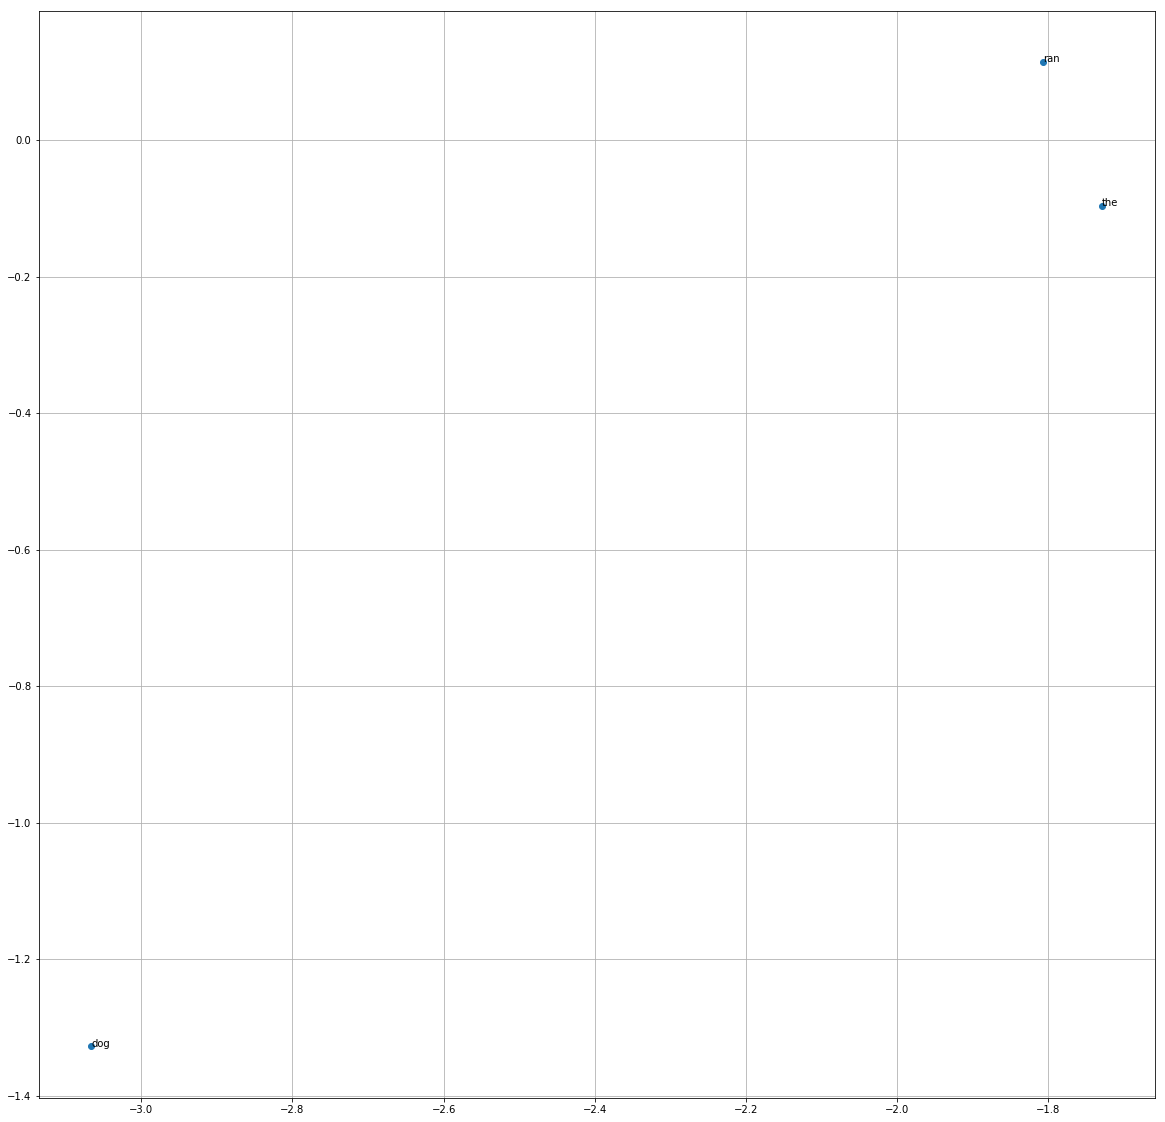

In [0]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### II.2.1 Word Similarity

#### II.2.2 Embedding Layer

#### II.2.3 Projection Layer

### II.3 Scoring

#### II.3.2 Highest and Lowest scoring sequences

#### II.3.3 Modified sequences

### II.4 Sampling

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

#### II.4.4 Example Samples